In [33]:


%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
sys.path.append('../util')
import torch
import torch.nn as nn

from abstractModule import AbstractLinear as AL
from abstractModule import AbstractReLU as AR
from abstractModule import AbstractMaxpool2D as AM
from abstractWeight import AbstractWeight as AW
from abstractNN import AbstractNN as NN
from custom_train import CustomTrainer as T
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch import optim
import os

import numpy as np
device = torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:

path ='dataset'

os.makedirs(path, exist_ok=True)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.5], std =[0.2]),
        #transforms.Resize((56,56))
    ])



dataset_train = datasets.FashionMNIST(root = path,transform = transform, download = True, train = True)
dataset_test =datasets.FashionMNIST( root =path,transform=transform ,download = True, train = False)
val =0.2
len_data_train = len(dataset_train)
train_size =int((1-val)*len_data_train)

val_size = int(val*len_data_train)

train_dataset, val_dataset = random_split(dataset_train, [train_size,val_size])


In [40]:


class AbstractNN(nn.Module):
    
    def __init__(self,num_depth=1,device=torch.device("cpu")):

        super(AbstractNN,self).__init__()
       
      
        self.num_depth = num_depth
        self.device = device
        self.conv1=nn.Conv2d(self.num_depth,16,3,device=self.device)
        self.conv2=nn.Conv2d(16,32,3,device=self.device)
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
  

       

        self.fc1=nn.Sequential(nn.Flatten(),nn.Linear(4608,64,device=self.device))
        self.fc2=nn.Sequential(nn.Flatten(),nn.Linear(64,10,device=self.device))
        self.softMax =nn.Softmax()
    def forward(self,x):
        x=self.conv1(x)
        x=torch.relu(x)
        x=self.conv2(x)
        x=torch.relu(x)
     
        x=self.maxpool(x)
     
    
        x=self.fc1(x)
        x=torch.relu(x)
        x=self.fc2(x)
        x=torch.relu(x)
        x= self.softMax(x)
        return x
    
    def abstract_forward(self,x,conv1_eps_weight,conv1_eps_bias,add_symbol=False,device=torch.device("cpu")):
        self.device=device
        AR.max_symbol = np.inf
        AM.max_symbol = np.inf
        AR.recycling = 1
        AM.recycling =1 
        
        x_true = x
        x_true = x_true[0].unsqueeze(0)

        x,x_min,x_max,x_true = NN.abstract_conv2D(self.conv1,x,x_true,conv1_eps_weight , conv1_eps_bias,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
     
       
        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        x,x_min,x_max ,x_true = AM.abstract_maxpool2D(self.maxpool,x,x_true,add_symbol=add_symbol,device=self.device)
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc1,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
      
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
       
        
        return x,x_min,x_max,x_true
        

Label:5


torch.Size([2, 1, 28, 28])

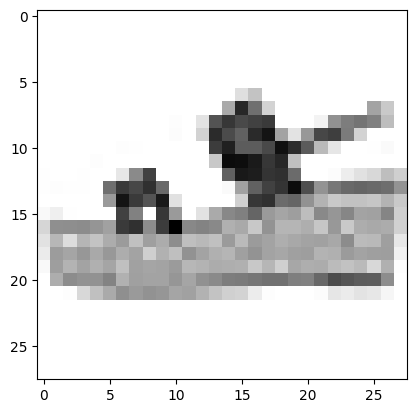

In [140]:

import matplotlib.pyplot as plt
import numpy as np

img, label = dataset_train[12]
plt.imshow(1-img[0],cmap='gray')
print(f"Label:{label}")
img.shape
from abstract import abstractTensor as AT

x=AT(img,alpha =torch.tensor([]))
x=x.abstract_tensor()
x.shape

In [84]:

model.conv1.weight.data.shape
conv1_eps_weight = torch.tensor([])
conv1_eps_weight.indices = torch.arange(0,len(model.conv1.weight.data.flatten()),1)
conv1_eps_weight.values = 0.01*torch.ones_like(conv1_eps_weight.indices)
conv1_eps_bias = torch.tensor([])
conv1_eps_bias.indices = torch.arange(0,len(model.conv1.bias.data.flatten()),1)
conv1_eps_bias.values = 0.01*torch.ones_like(conv1_eps_bias.indices)

In [131]:
model = AbstractNN()

In [69]:
model.abstract_forward(x,conv1_eps_bias=conv1_eps_bias,conv1_eps_weight=conv1_eps_weight)

(tensor([[ 7.1716e-01,  8.6607e-01,  1.0026e+00,  ...,  7.4909e-01,
           8.3954e-01,  8.6511e-01],
         [ 1.0047e-04,  8.5730e-05, -6.8600e-06,  ...,  3.3589e-04,
           2.0453e-05, -9.3366e-05],
         [ 5.4480e-05,  7.7197e-05, -8.0038e-06,  ...,  3.1352e-04,
           3.6553e-05, -9.8966e-05],
         ...,
         [-2.2426e-05,  1.3489e-05, -1.9109e-05,  ...,  1.7114e-05,
           1.6074e-05, -2.8868e-05],
         [-1.2733e-05, -3.7648e-07, -1.0526e-05,  ..., -1.1241e-05,
          -1.3020e-05, -1.7334e-05],
         [ 2.3687e+00,  2.5242e+00,  2.7182e+00,  ...,  2.5809e+00,
           2.3990e+00,  2.3936e+00]]),
 tensor([-1.6559, -1.6645, -1.7197, -1.5318, -1.6599, -1.5816, -1.6349, -1.8388,
         -1.5639, -1.5338]),
 tensor([3.0902, 3.3967, 3.7250, 2.9942, 3.1301, 2.9983, 3.2318, 3.3370, 3.2429,
         3.2640]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [141]:
with torch.no_grad():

   result,x_min,x_max,x_true=model.abstract_forward(x,conv1_eps_bias=conv1_eps_bias,conv1_eps_weight=conv1_eps_weight,add_symbol=True)

print(f"y_min       =  {x_min}")
print(f"y_max       =  {x_max}")
print(f"center Ztp  =  {result[0]}")
print(f"y_true      =  {x_true[:]}")
print(f"y_max-x_min =  {x_max-x_min}")
print(f"Trash symbol=  {result[-1]}")

y_min       =  tensor([2.3299, 2.1110, 0.2580, 0.0473, 0.0543, 1.9400, 1.0883, 0.0000, 0.6802,
        0.0000])
y_max       =  tensor([2.4346, 2.2180, 0.3603, 0.1447, 0.1616, 2.0410, 1.1829, 0.0000, 0.7790,
        0.0000])
center Ztp  =  tensor([2.3822, 2.1645, 0.3091, 0.0960, 0.1079, 1.9905, 1.1356, 0.0000, 0.7296,
        0.0000])
y_true      =  tensor([[2.3874, 2.1660, 0.3104, 0.0968, 0.1087, 1.9922, 1.1365, 0.0000, 0.7281,
         0.0000]])
y_max-x_min =  tensor([0.1047, 0.1070, 0.1023, 0.0974, 0.1073, 0.1010, 0.0947, 0.0000, 0.0989,
        0.0000])
Trash symbol=  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [86]:
result.shape

torch.Size([4281, 10])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


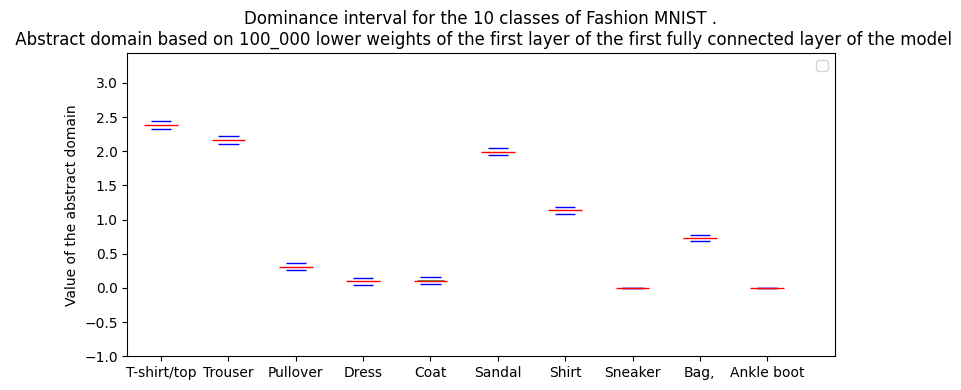

In [142]:

y_min       =  np.array(x_min)
y_max       =  np.array(x_max)
center_Ztp  =  np.expand_dims(np.array(result[0]),axis =1)
y_true      =  np.expand_dims(np.array(x_true[:])[0],axis =1)
y_max_minus_y_min =  np.array(x_max-x_min)
Trash_symbol=  np.array(result[-1])


import matplotlib.pyplot as plt
import numpy as np




x_final = np.arange(len(y_min))
D =np.stack((y_min,y_max),axis=1)

print(D.shape)
print(center_Ztp.shape)
print(y_true.shape)
# plot:

fig,ax = plt.subplots(1, 1, figsize=(8,4), tight_layout=True)
ax.eventplot(D, orientation="vertical", linewidth=1,color='blue',linelengths=0.3)
ax.eventplot(y_true, orientation="vertical", linewidth=0.50,color='green',linelengths=0.4)
ax.eventplot(center_Ztp, orientation="vertical", linewidth=1,color='red',linelengths=0.5)

ax.set(xlim=(-0.5, 10),xticks=x_final,xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"],
       ylim=(np.min(D)-1, np.max(D)+1))
plt.ylabel("Value of the abstract domain")
plt.title("Dominance interval for the 10 classes of Fashion MNIST .\n Abstract domain based on 100_000 lower weights of the first layer of the first fully connected layer of the model")
plt.legend()
plt.show()

In [134]:

from tqdm import tqdm

for i in tqdm(range(100)):

    img, label = dataset_train[i]

   
   
    from abstract import abstractTensor as AT

    x=AT(img,alpha =torch.tensor([]))
    x=x.abstract_tensor()
    x.shape

    
  
    with torch.no_grad():
      
        
        result,x_min,x_max,x_true=model.abstract_forward(x,conv1_eps_bias=conv1_eps_bias,conv1_eps_weight=conv1_eps_weight,add_symbol=True)

    concatenated_tensors = []
    for i in range(10):
        concat_part = result[1:145, i].view(16, 1, 3, 3)
        concatenated_tensors.append(concat_part)
    concatenated_tensors =torch.stack(concatenated_tensors)
    

    model.conv1.weight.data =model.conv1.weight.data+1000*(2*concatenated_tensors[label]-torch.sum(concatenated_tensors,dim =0))


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


In [107]:
list

['concat_0',
 'concat_1',
 'concat_2',
 'concat_3',
 'concat_4',
 'concat_5',
 'concat_6',
 'concat_7',
 'concat_8',
 'concat_9']

In [89]:
conv1_eps_weight.values
model.conv1.weight.data

tensor([[[[-1.0416, -0.5239, -0.0038],
          [-1.9786,  0.5469,  0.2443],
          [-1.0603, -0.1609, -0.5895]]],


        [[[-0.3194,  0.8343,  0.3195],
          [-0.3141,  0.1728, -0.0438],
          [-0.0570,  0.0395, -0.6312]]],


        [[[ 0.5194,  1.1976,  0.3797],
          [-0.1779,  0.4808,  0.4696],
          [-1.2317, -0.8611, -0.4534]]],


        [[[-0.1151,  0.8267,  0.4215],
          [-0.4855,  0.1022,  0.5529],
          [-0.0046,  0.2769,  0.4255]]],


        [[[ 0.1636, -0.9789, -1.3291],
          [-0.6103,  0.0657, -0.0788],
          [ 0.1584,  0.7369, -1.4780]]],


        [[[ 0.0559,  1.4751,  1.2907],
          [-0.8420,  0.0771,  1.5336],
          [ 0.1112,  0.7167,  0.7355]]],


        [[[ 0.7340,  0.8412, -0.0638],
          [ 0.9516,  1.1310,  0.4010],
          [ 1.4213,  0.9585,  0.5983]]],


        [[[-0.8224, -0.2186, -1.1922],
          [-1.4202, -1.6673,  0.2787],
          [ 0.6846, -0.7302,  0.1073]]],


        [[[ 1.3146,  1.2520,  1.